In [90]:
import wandb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda

import gym

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [91]:
class Pendulum:
    
    def __init__(self, env, iden = 0):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.action_bound = self.env.action_space.high[0]
        self.std_bound = [1e-2, 1.0]

        self.iden = iden
    
    def train(self, max_episodes=1000):
        for ep in range(max_episodes):
            state_batch = []
            action_batch = []
            reward_batch = []
            old_policy_batch = []

            episode_reward, done = 0, False

            state = self.env.reset()

            while not done:
                # self.env.render()
                log_old_policy, action = self.actor.get_action(state)

                next_state, reward, done, _ = self.env.step(action)

                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, 1])
                next_state = np.reshape(next_state, [1, self.state_dim])
                reward = np.reshape(reward, [1, 1])
                log_old_policy = np.reshape(log_old_policy, [1, 1])

            print('EP{} EpisodeReward={}'.format(ep, episode_reward))
            wandb.log({'Reward' + str(self.iden): episode_reward})

In [98]:
class Agent:
    
    def __init__(self, env, num=1):
        
        # initial proportional controller
        # real and test (test used for gradient descent)f
        # need to be numpy vectors

        
#         self.Kp_t = self.Kp
#         self.gain_t = self.gain
        
#         self.x0 = x0
        
        self.radius = 0.001
        self.alpha = 0.003
        self.num = num
         
        # define the environment
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.action_bound = self.env.action_space.high[0]
        self.std_bound = [1e-2, 1.0]

        self.Kp = np.random.randn(self.state_dim)
        self.gain = np.random.randn(self.action_dim)
        
    # Simulate the environment and get the reward out
    def simulate(self, prop, g):
        state_batch = []
        action_batch = []
        reward_batch = []
        old_policy_batch = []

        episode_reward, done = 0, False

        state = self.env.reset()

        # define the action taken
        def get_action(st):
            action = prop @ state + g
            return(action)
        
        while not done:
            action = get_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = np.reshape(state, [1, self.state_dim])[0]
            action = np.reshape(action, [1, 1])[0]
            next_state = np.reshape(next_state, [1, self.state_dim])[0]
            reward = np.reshape(reward, [1, 1])[0]
            
            episode_reward += reward

#         print('EP{} EpisodeReward={}'.format(ep, episode_reward))
#         wandb.log({'Reward' + str(self.iden): episode_reward})
        return episode_reward

    
    def learn(self):
        
         # pick a vector on unit sphere to move Kp in
        # vec = (np.random.rand(self.Kp.size + self.gain.size) - 0.5)
        vec = (np.random.rand(self.Kp.size + 1) - 0.5)
        vec = self.radius * vec / np.linalg.norm(vec)
        vec_k = np.reshape(vec[:self.Kp.size], self.Kp.shape)

        vec_g = vec[-1:]

#         rand_start = self.x0#  + np.random.randn(self.x0.size) * 0.1

        # two-point gradient descent estimate
        self.Kp_t = self.Kp + vec_k
        self.gain_t = self.gain + vec_g
        err1 = self.simulate(self.Kp_t, self.gain_t)

        self.Kp_t = self.Kp - vec_k
        self.gain_t = self.gain - vec_g
        err2 = self.simulate(self.Kp_t, self.gain_t)
        
        z_step =  (self.Kp.size + self.gain.size / (2 * self.radius)) * (err1 - err2)
        self.Kp = self.Kp - self.alpha * z_step * vec_k
        self.gain = self.gain - self.alpha / self.num * z_step * vec_g
        

In [93]:
env_name = 'Pendulum-v0'
env = gym.make(env_name)

Kp = np.array([0, 0, 0])
gain = np.array([0])

ag = Agent(env, Kp, gain)

rewards = []
rewards.append(ag.simulate(ag.Kp, ag.gain)[0])
print(rewards[-1])
for _ in range(5):
    for _ in range(5):
        ag.learn()
    rewards.append(ag.simulate(ag.Kp, ag.gain)[0])
    print(rewards[-1])
    


TypeError: __init__() takes from 2 to 3 positional arguments but 4 were given

In [99]:
## Multiagent version now
env_name = 'Pendulum-v0'
env = gym.make(env_name)

# Kp = np.array([0, 0, 0])
# gain = np.array([0])
num = 3

agents = []
for i in range(num):
    ag = Agent(env, num)
    agents.append(ag)

rewards = []
rewards.append(ag.simulate(ag.Kp, ag.gain)[0])
print(rewards[-1])
for _ in range(400):
    
    Kp_avg = np.zeros(Kp.shape)
    gain_avg = np.zeros(gain.shape)
    for i in range(num):
        for _ in range(5):
            agents[i].learn()
        
        
#         print(agents[i].Kp, agents[i].gain)
        
        
        Kp_avg += agents[i].Kp
        gain_avg += agents[i].gain
        
    
    Kp_avg /= num
    gain_avg /= num
#     print(Kp_avg, gain_avg)
    for i in range(num):
        agents[i].Kp = Kp_avg
        agents[i].gain = gain_avg
    
    rewards.append(agents[0].simulate(ag.Kp, ag.gain)[0])
    print(rewards[-1])

-1666.736487829501
-805.8816189386534
-1684.6434528622647
-1670.7690489782742
-1184.5517347547652
-1166.7148277995823
-1292.089697457613
-1481.0130598792998
-1349.3496607030545
-1342.5877150455165
-919.2668046181756
-1434.626486963755
-1653.6275368567026
-1645.7678390929461
-1655.6775642937787
-1275.7901637182333
-1557.0083062124074
-1616.2217142235208
-833.5048186097906
-1520.7475394612745
-1438.6286879231027
-1640.5678836578427
-1381.1082247149754
-1466.284683630237
-1533.6541469404528
-1540.2907249781117
-1061.0725799069717
-1495.1108636589722
-1645.000525950507
-1241.8526271277765
-1588.7214274420407
-1657.0829034569117
-1656.9282350861326
-1035.0887983746077
-1278.885238837836
-1268.7885260515732
-1608.9083421941841
-1238.0958370459814
-1651.3102687786768
-1656.9001690696293
-1168.9529268733545
-1393.0729713593098
-1298.9364415698901
-1425.2309581764036
-1657.730740057793
-1585.09886519916
-1654.6084421420367
-1628.483896870723
-1219.4251308928524
-1639.7129186110003
-1657.1418822

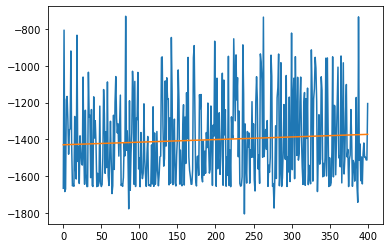

In [100]:
epochs = np.arange(len(rewards))
plt.plot(epochs, rewards)
plt.plot(np.unique(epochs), np.poly1d(np.polyfit(epochs, rewards, 1))(np.unique(epochs)))

plt.show()